<a href="https://colab.research.google.com/github/rumijay/Data-Science-2025/blob/main/Rumi_Jawad_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You need to submit a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U3proj.

Ex.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU3proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU2proj.ipynb"

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- All students are allowed to use this data set: [NBA player data from the 2023-2024 season](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). Why? This is could lead to similar analysis as the soccer data analysis--basically, I think this data set will work well with the models we ran in class. Let me know if you have questions about downloading and cleaning the data.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- Want an example? The Unit4NotesAK *is* your example! You are expected to be somewhere between a half and three-quarters as detailed--but more is always welcome.

- I didn't totally understand the chemical shift context--which means you don't have to totally understand the context of your data either! You should try to learn as you go, though.


# Unit 4 Project: Using Hierarchies to Account for Dependence Between Groups

**Task**:

Two parts:

1. Propose a data set that's compatible with a hierarchical model structure built with pymc, and that potentially has some dependence between subgroups within the data set. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a model using pymc within the colab environment, on a data set of your choice, with the following restrictions
- You must have at least one piror and at least one hyperprior.
- Your model must have at least one seperate prior for each subgroup of the data set, and a at least one shared hyperior for all the groups.
- Any student may use the following data set: [basketball2324](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). I recommend trying to model TRB (total rebounds) by player position (pos). Also, I recommend pandas query function to splice and clean the data.



In [16]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm



Context: I chose this dataset because it was provided to me, and I do not want go through the hardships of finding my own dataset, because last time my dataset cooked me.

In [17]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://github.com/rumijay/Data-Science-2025/raw/main/Rumi%20data.xlsx'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_excel(url_cs)

In [18]:
#load the NBA data from the provided github page.
url_nba = 'https://github.com/thedarredondo/data-science-fundamentals/raw/main/Data/basketball2324.csv'

#Turns the position column into a categorical variable
# pd.read_csv is more appropriate for .csv files
sccr_data = pd.read_csv(url_nba, dtype={'Pos':'category'})

In [19]:
sccr_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


I removed everything but Pos and TRB.

In [20]:
cs_data


,Player,Pos,TRB
0,Ja Morant,PG,50
1,Marcus Morris,PF,134
2,Markieff Morris,PF,39
3,Monte Morris,PG,57
4,Trey Murphy III,SF,280
...,...,...,...
210,Thaddeus Young,PF,103
211,Trae Young,PG,149
212,Omer Yurtseven,C,208
213,Cody Zeller,C,112


In [21]:
dag_cs = gv.Digraph(comment='cs_dag') #cs for chemical shift

dag_cs.node('E', 'Rebounds')
dag_cs.node('T','Position')
dag_cs.node('D','Difference between Rebounds and Position')
#dag_cs.node('A','Amino Acid Type')

dag_cs.edges(['ED','TD', ])

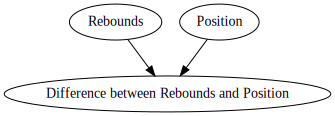

In [22]:
dag_cs

In [23]:
#this is an array of the NBA positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.Pos.astype('category').cat.codes.values

#an array of the position strings
pos_codes = sccr_data.Pos.astype('category').cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [24]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters for the log of the mean TRB rate for each position
    # mu_log_lambda: shared mean for the log rates across positions (hyperprior)
    # The prior mean is initialized with the log of the overall mean TRB for better convergence.
    mu_log_lambda = pm.Normal('mu_log_lambda', mu=pm.math.log(sccr_data['TRB'].mean()), sigma=2)
    # sigma_log_lambda: shared standard deviation for the log rates across positions (hyperprior)
    sigma_log_lambda = pm.HalfNormal('sigma_log_lambda', sigma=1)

    # Parameters for positions (priors for each subgroup)
    # log_lambda_pos: log of the mean TRB rate for each position, drawn from the hierarchical Normal distribution
    log_lambda_pos = pm.Normal('log_lambda_pos', mu=mu_log_lambda, sigma=sigma_log_lambda, dims="pos")
    # lambda_pos: mean TRB rate for each position (exponentiated log_lambda_pos)
    lambda_pos = pm.Deterministic('lambda_pos', pm.math.exp(log_lambda_pos))

    # Likelihood for players' TRB
    # TRB for each player is observed from a Poisson distribution
    # with a rate determined by their position (lambda_pos[pos_idx])
    _ = pm.Poisson('trb_obs',
                   mu=lambda_pos[pos_idx],
                   observed=sccr_data['TRB'].values)

    # Sample the model
    # Increased draws and tune steps for better sampling and convergence
    idata_sccr = pm.sample(target_accept = 0.95, draws=2000, tune=2000)

Output()

array([[<Axes: title={'center': 'lambda_pos'}>,
        <Axes: title={'center': 'lambda_pos'}>],
       [<Axes: title={'center': 'log_lambda_pos'}>,
        <Axes: title={'center': 'log_lambda_pos'}>],
       [<Axes: title={'center': 'mu_log_lambda'}>,
        <Axes: title={'center': 'mu_log_lambda'}>],
       [<Axes: title={'center': 'sigma_log_lambda'}>,
        <Axes: title={'center': 'sigma_log_lambda'}>]], dtype=object)

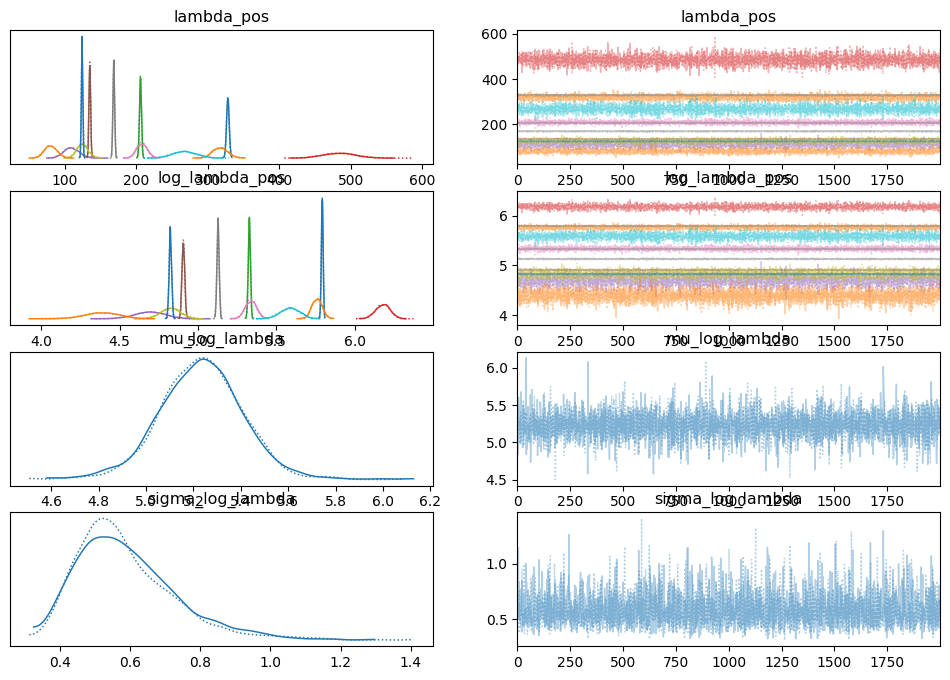

In [25]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

In [28]:
sns.violinplot(sccr_data.goals,inner='quart')

AttributeError: 'DataFrame' object has no attribute 'goals'

In [29]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

KeyError: 'var names: "[\'μ_p\'] are not present" in dataset'